# 示例：使用框架训练图像分类模型

利用框架提供的模块，我们可以十分方便地训练深度学习模型。以 Kaggle 图像数据集 <https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals/data> 为例。

In [1]:
import torch 
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

## 1. 数据集

将数据下载并解压到 `data` 目录下：解压后的结构为

```
data/mammals/
        |-  african_elephant/
        |   |-  african_elephant-0001.jpg
        |   |-  *
        |
        |-  alpaca/
        |   |-  alpaca-0001.jpg
        |   |-  *
        |
        *
```

由于数据集中并未划分训练集和测试集，我们需要通过下面的单元格对数据集进行划分。或者你可以采用仓库作者生成的划分方式：`data/mammals_split/`

In [2]:
# 需要重新划分数据集，请将本单元格的最后一行取消注释并运行

from pathlib import Path 
import random 

# 获取所有的类别
def split_dataset(root: str = "data", split_prob: float = 0.8, seed: int = 0) -> None:
    r""" split the dataset
    
    root (pathlike): diretory where 'mammals/' lays.
    split_prob (float): the ratio of train-set against test-set.
    seed (int): random number generator seed.
    """
    root_dir = Path(root)
    labels = []
    train = []
    test = []
    label_idx = 0
    
    # 固定随机种子
    random.seed(seed)
    
    # 获取类名称并将图片分入训练或测试集
    for sub_dir in (root_dir / "mammals").glob("*"):
        labels.append(sub_dir.stem)
        for file_path in sub_dir.glob("*"):
            split = train if random.random() < split_prob else test
            split.append((file_path.name, label_idx))
        label_idx += 1

    split_dir = root_dir / "mammals_split"
    split_dir.mkdir(parents=True, exist_ok=True)

    # 写入 labels.txt
    with open(split_dir / "labels.txt", "w") as f:
        for i, label in enumerate(labels):
            f.write(label + "\n")

    # 写入 train.txt
    with open(split_dir / "train.txt", "w") as f:
        for file_name, label in train:
            f.write(file_name + f",{label}\n")

    # 写入 test.txt
    with open(split_dir / "test.txt", "w") as f:
        for file_name, label in test:
            f.write(file_name + f",{label}\n")

# 重新划分数据集时，请指定随机种子
# split_dataset(seed=0)

搭建数据集类：`src.modules.SizedDatast`，访问该数据集对象得到的数据类型为
```
{
    "image": torch.Tensor,
    "label": int
}
```

In [3]:
from PIL import Image
from src.modules import SizedDataset
from pathlib import Path
from typing import Callable, cast
from typing_extensions import TypedDict
from torchvision import transforms


class Data(TypedDict):
    image: torch.Tensor 
    label: int


class MammalsDataset(SizedDataset):
    r""" Dataset of mammals images
    
    root (pathlike): directory where 'mammals/' and 'mammals_split/' locate.
    train (bool): whether load the train-dataset or the test-dataset.
    """
    def __init__(
        self, 
        root: str, 
        train: bool = True, 
        transforms: Callable =  transforms.Compose([
            transforms.CenterCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ) -> None:
        super().__init__()
        self.root: Path = Path(root).absolute()
        self.train: bool = train
        self.labels: list[str] = self.__read_labels()
        self.data: list[dict] = self.__read_data()
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int) -> Data:
        path = self.__image_dir / self.data[index]["path"]
        label = self.data[index]["label"]
        image = self.transforms(Image.open(path))
        return {
            "image": cast(torch.Tensor, image),
            "label": label
        }
        
    
    @property
    def __image_dir(self): return self.root / "mammals"
    
    @property
    def __split_dir(self): return self.root / "mammals_split"
    
    @property
    def __label_file(self): return self.__split_dir / "labels.txt"
    
    @property
    def __split_file(self): 
        name = "train.txt" if self.train else "test.txt"
        return self.__split_dir / name 
    
    def __read_labels(self) -> list[str]:
        labels = []
        with open(self.__label_file, "r") as f:
            for line in f.readlines():
                labels.append(line.strip())
        return labels
    
    def __read_data(self) -> list[dict]:
        data = []
        with open(self.__split_file, "r") as f:
            for line in f.readlines():
                [name, label_index] = line.strip().split(",")
                label_index = int(label_index)
                dic: dict = {
                    "path": self.labels[label_index] + "/" + name,
                    "label": label_index
                }
                data.append(dic)
        return data
        

展示数据

opossum


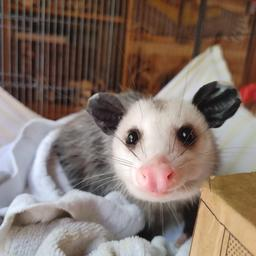

In [4]:
import random

image_dataset = MammalsDataset("../data/", transforms=lambda x: x )
index = random.randint(0, len(image_dataset)-1)

print(image_dataset.labels[image_dataset[index]["label"]])
image_dataset[index]["image"]

## 2. 神经网络模型
搭建 `src.modules.NeuralNetwork` 类。具体的，使用一个 `torchvision.models.resnet18` 实例并更换其分类头为 45 类，该分类头返回的是对应数据的 logits 值

In [5]:
import torch
from torch.nn import Linear
from torchvision.models import resnet18, resnet34
from src.modules import NeuralNetwork 
from typing import Literal

class ResNet(NeuralNetwork):
    
    def __init__(
        self, 
        resnet: Literal["resnet18", "resnet34"] = "resnet18", 
        use_pretrained: bool = False,
        freeze_backbone: bool = False
    ) -> None:
        super().__init__()
        if resnet == "resnet18":
            self.resnet = resnet18(pretrained=use_pretrained)
        elif resnet == "resnet34":
            self.resnet = resnet34(pretrained=use_pretrained)
        
        if freeze_backbone:
            for name, params in self.resnet.named_parameters():
                if "fc" in name:
                    continue
                params.requires_grad = False 
        self.resnet.fc = Linear(self.resnet.fc.in_features, 45, bias=True)
        self.freeze_backbone = freeze_backbone
    
    def forward(self, input_: torch.Tensor) ->torch.Tensor:
        return self.resnet(input_)
    
    def init_weights(self):
        if self.freeze_backbone:
            self.resnet.fc.reset_parameters()
            return self
        else:
            super().init_weights()

In [6]:
net = ResNet(resnet="resnet18", use_pretrained=True, freeze_backbone=True)
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.requires_grad)

/scratch/shenty/miniconda3/envs/torch-train/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shenty/miniconda3/envs/torch-train/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet.fc.weight True
resnet.fc.bias True


## 3. 训练算法模型

编写 `src.modules.TrainModel` 类来管理损失函数。分类模型使用交叉熵函数来优化。

In [7]:
import torch 
from src.modules import NeuralNetwork, TrainModel


class TrainClassifyMammals(TrainModel):
    loss_fn = torch.nn.CrossEntropyLoss()
    _loss_weights = {"cross-entropy": 1.}
    
    def compute_loss(self, network: NeuralNetwork, batch: Data) -> dict:
        images = batch["image"]
        labels = batch["label"]
        
        logits = network(images)
        
        return {
            "cross-entropy": self.loss_fn(logits, labels)
        }

## 4. 训练器与插件

超参数：
- 训练轮数：10
- 批次大小：128
- 学习率：0.001
- 初始随机种子：0

拓展插件：
- `InitializeNetworkPlugin`：随机初始化网络权重
- `SaveCheckpointPlugin`：保存检查点
- `EvaluatePlugin`：epoch末尾评估模型，需要定义 `EvaluateModel`
- `LossLoggerPlugin` 和 `MetricLoggerPlugin`
- `ProgressBarPlugin`

In [8]:
import torch
from torch.utils.data import DataLoader
from src.modules import EvaluateModel, NeuralNetwork
from src.utils import move_batch

class EvaluateClassifyMammalsTest(EvaluateModel):
    def __init__(self, root, batch_size, device="cpu") -> None:
        self._metrics = ["accuracy"]
        self.dataset = MammalsDataset(root, train=False)
        self.batch_size = batch_size
        self.device = torch.device(device)
    
    @torch.no_grad()
    def predict_batch_labels(self, network, batch_images):
        network.eval()
        logits = network(batch_images)
        pred = torch.argmax(logits, dim=1)
        return pred
    
    def evaluate(self, network: NeuralNetwork) -> dict[str, float]:
        network.to(self.device)
        correctness = 0
        for batch in DataLoader(self.dataset, batch_size=self.batch_size, num_workers=4):
            batch = move_batch(batch, self.device)
            images = batch["image"]
            labels = batch["label"]
            
            pred = self.predict_batch_labels(network, images)
            correctness += (pred == labels).sum().item()
        return {"accuracy": correctness / len(self.dataset)}

In [9]:
# exp-1
from pathlib import Path
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    LoadCheckpointPlugin,
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin
)

EXP_INDEX = 1

# Hyper Parameters
DATA_DIR = "../data/"
NUM_EPOCH = 40
BATCH_SIZE = 128
LEARNING_RATE = 0.001

SEED = 0
DEVICE = "cuda"

EVAL_PERIOD = 2

OUTPUT_DIR = Path("../OUTPUTs/mammals").absolute()
LOG_DIR = OUTPUT_DIR / "log" / f"exp-{EXP_INDEX}"
LOG_PERIOD = 5
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint" / f"exp-{EXP_INDEX}"
CHECKPOINT_PERIOD = 10


# modules
dataset = MammalsDataset(root=DATA_DIR)
network = ResNet()
optimizer = Adam(network.parameters(), lr=LEARNING_RATE)
train_model = TrainClassifyMammals()
eval_model = EvaluateClassifyMammalsTest(root=DATA_DIR, batch_size=BATCH_SIZE, device=DEVICE)

# trainer
trainer = (
    Trainer(
        train_model,
        num_epochs=NUM_EPOCH,
        batch_size=BATCH_SIZE,
        init_seed=SEED,
        device="cuda"
    )
    # .add_plugin(LoadCheckpointPlugin("../OUTPUTs/mammals/checkpoint/exp-1/epoch-20/"))
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(LossLoggerPlugin(log_dir=LOG_DIR, log_period=LOG_PERIOD))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=EVAL_PERIOD))
    .add_plugin(MetricLoggerPlugin(log_dir=LOG_DIR, log_period=EVAL_PERIOD))
    .add_plugin(SaveCheckpointPlugin(saving_dir=CHECKPOINT_DIR, saving_period=CHECKPOINT_PERIOD))
    .add_plugin(ProgressBarPlugin())
)

In [13]:
# exp-2
from pathlib import Path
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    LoadCheckpointPlugin,
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin
)

EXP_INDEX = 2

# Hyper Parameters
DATA_DIR = "../data/"
NUM_EPOCH = 40
BATCH_SIZE = 128
LEARNING_RATE = 0.001

SEED = 0
DEVICE = "cuda"

EVAL_PERIOD = 2

OUTPUT_DIR = Path("../OUTPUTs/mammals").absolute()
LOG_DIR = OUTPUT_DIR / "log" / f"exp-{EXP_INDEX}"
LOG_PERIOD = 5
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint" / f"exp-{EXP_INDEX}"
CHECKPOINT_PERIOD = EVAL_PERIOD


# modules
dataset = MammalsDataset(root=DATA_DIR)
network = ResNet("resnet34")
optimizer = Adam(network.parameters(), lr=LEARNING_RATE)
train_model = TrainClassifyMammals()
eval_model = EvaluateClassifyMammalsTest(root=DATA_DIR, batch_size=BATCH_SIZE, device=DEVICE)

# trainer
trainer = (
    Trainer(
        train_model,
        num_epochs=NUM_EPOCH,
        batch_size=BATCH_SIZE,
        init_seed=SEED,
        device="cuda"
    )
    # .add_plugin(LoadCheckpointPlugin("../OUTPUTs/mammals/checkpoint/exp-2/epoch-20/"))
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(LossLoggerPlugin(log_dir=LOG_DIR, log_period=LOG_PERIOD))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=EVAL_PERIOD))
    .add_plugin(MetricLoggerPlugin(log_dir=LOG_DIR, log_period=EVAL_PERIOD))
    .add_plugin(SaveCheckpointPlugin(saving_dir=CHECKPOINT_DIR, saving_period=CHECKPOINT_PERIOD))
    .add_plugin(ProgressBarPlugin())
)

In [15]:
# exp-3
from pathlib import Path
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    LoadCheckpointPlugin,
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin
)

EXP_INDEX = 3

# Hyper Parameters
DATA_DIR = "../data/"
NUM_EPOCH = 40
BATCH_SIZE = 128
LEARNING_RATE = 0.01

SEED = 0
DEVICE = "cuda"

EVAL_PERIOD = 2

OUTPUT_DIR = Path("../OUTPUTs/mammals").absolute()
LOG_DIR = OUTPUT_DIR / "log" / f"exp-{EXP_INDEX}"
LOG_PERIOD = 5
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint" / f"exp-{EXP_INDEX}"
CHECKPOINT_PERIOD = EVAL_PERIOD


# modules
dataset = MammalsDataset(root=DATA_DIR)
network = ResNet("resnet34")
optimizer = Adam(network.parameters(), lr=LEARNING_RATE)
train_model = TrainClassifyMammals()
eval_model = EvaluateClassifyMammalsTest(root=DATA_DIR, batch_size=BATCH_SIZE, device=DEVICE)

# trainer
trainer = (
    Trainer(
        train_model,
        num_epochs=NUM_EPOCH,
        batch_size=BATCH_SIZE,
        init_seed=SEED,
        device="cuda"
    )
    # .add_plugin(LoadCheckpointPlugin("../OUTPUTs/mammals/checkpoint/exp-2/epoch-20/"))
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(LossLoggerPlugin(log_dir=LOG_DIR, log_period=LOG_PERIOD))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=EVAL_PERIOD))
    .add_plugin(MetricLoggerPlugin(log_dir=LOG_DIR, log_period=EVAL_PERIOD))
    .add_plugin(SaveCheckpointPlugin(saving_dir=CHECKPOINT_DIR, saving_period=CHECKPOINT_PERIOD))
    .add_plugin(ProgressBarPlugin())
)

In [17]:
# exp-4
from pathlib import Path
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    LoadCheckpointPlugin,
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin
)

EXP_INDEX = 4

# Hyper Parameters
DATA_DIR = "../data/"
NUM_EPOCH = 40
BATCH_SIZE = 256
LEARNING_RATE = 0.001

SEED = 0
DEVICE = "cuda"

EVAL_PERIOD = 2

OUTPUT_DIR = Path("../OUTPUTs/mammals").absolute()
LOG_DIR = OUTPUT_DIR / "log" / f"exp-{EXP_INDEX}"
LOG_PERIOD = 5
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint" / f"exp-{EXP_INDEX}"
CHECKPOINT_PERIOD = EVAL_PERIOD


# modules
dataset = MammalsDataset(root=DATA_DIR)
network = ResNet("resnet18")
optimizer = Adam(network.parameters(), lr=LEARNING_RATE)
train_model = TrainClassifyMammals()
eval_model = EvaluateClassifyMammalsTest(root=DATA_DIR, batch_size=BATCH_SIZE, device=DEVICE)

# trainer
trainer = (
    Trainer(
        train_model,
        num_epochs=NUM_EPOCH,
        batch_size=BATCH_SIZE,
        init_seed=SEED,
        device="cuda"
    )
    # .add_plugin(LoadCheckpointPlugin("../OUTPUTs/mammals/checkpoint/exp-2/epoch-20/"))
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(LossLoggerPlugin(log_dir=LOG_DIR, log_period=LOG_PERIOD))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=EVAL_PERIOD))
    .add_plugin(MetricLoggerPlugin(log_dir=LOG_DIR, log_period=EVAL_PERIOD))
    .add_plugin(SaveCheckpointPlugin(saving_dir=CHECKPOINT_DIR, saving_period=CHECKPOINT_PERIOD))
    .add_plugin(ProgressBarPlugin())
)

In [ ]:
# exp-5
from pathlib import Path
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    LoadCheckpointPlugin,
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin
)

EXP_INDEX = 5

# Hyper Parameters
DATA_DIR = "../data/"
NUM_EPOCH = 40
BATCH_SIZE = 256
LEARNING_RATE = 0.001

SEED = 0
DEVICE = "cuda"

EVAL_PERIOD = 2

OUTPUT_DIR = Path("../OUTPUTs/mammals").absolute()
LOG_DIR = OUTPUT_DIR / "log" / f"exp-{EXP_INDEX}"
LOG_PERIOD = 5
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint" / f"exp-{EXP_INDEX}"
CHECKPOINT_PERIOD = EVAL_PERIOD


# modules
dataset = MammalsDataset(root=DATA_DIR)
network = ResNet("resnet18")
optimizer = Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=LEARNING_RATE)
train_model = TrainClassifyMammals()
eval_model = EvaluateClassifyMammalsTest(root=DATA_DIR, batch_size=BATCH_SIZE, device=DEVICE)

# trainer
trainer = (
    Trainer(
        train_model,
        num_epochs=NUM_EPOCH,
        batch_size=BATCH_SIZE,
        init_seed=SEED,
        device="cuda"
    )
    # .add_plugin(LoadCheckpointPlugin("../OUTPUTs/mammals/checkpoint/exp-2/epoch-20/"))
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(LossLoggerPlugin(log_dir=LOG_DIR, log_period=LOG_PERIOD))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=EVAL_PERIOD))
    .add_plugin(MetricLoggerPlugin(log_dir=LOG_DIR, log_period=EVAL_PERIOD))
    .add_plugin(SaveCheckpointPlugin(saving_dir=CHECKPOINT_DIR, saving_period=CHECKPOINT_PERIOD))
    .add_plugin(ProgressBarPlugin())
)

In [16]:
# exp-8
from pathlib import Path
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    LoadCheckpointPlugin,
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin
)

EXP_INDEX = 8

# Hyper Parameters
DATA_DIR = "../data/"
NUM_EPOCH = 40
BATCH_SIZE = 512
LEARNING_RATE = 0.01

SEED = 0
DEVICE = "cuda"

EVAL_PERIOD = 2

OUTPUT_DIR = Path("../OUTPUTs/mammals").absolute()
LOG_DIR = OUTPUT_DIR / "log" / f"exp-{EXP_INDEX}"
LOG_PERIOD = 5
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint" / f"exp-{EXP_INDEX}"
CHECKPOINT_PERIOD = EVAL_PERIOD


# modules
dataset = MammalsDataset(root=DATA_DIR)
network = ResNet("resnet18", use_pretrained=True, freeze_backbone=True)
optimizer = Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=LEARNING_RATE)
train_model = TrainClassifyMammals()
eval_model = EvaluateClassifyMammalsTest(root=DATA_DIR, batch_size=BATCH_SIZE, device=DEVICE)

# trainer
trainer = (
    Trainer(
        train_model,
        num_epochs=NUM_EPOCH,
        batch_size=BATCH_SIZE,
        init_seed=SEED,
        device="cuda"
    )
    # .add_plugin(LoadCheckpointPlugin("../OUTPUTs/mammals/checkpoint/exp-2/epoch-20/"))
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(LossLoggerPlugin(log_dir=LOG_DIR, log_period=LOG_PERIOD))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=EVAL_PERIOD))
    .add_plugin(MetricLoggerPlugin(log_dir=LOG_DIR, log_period=EVAL_PERIOD))
    .add_plugin(SaveCheckpointPlugin(saving_dir=CHECKPOINT_DIR, saving_period=CHECKPOINT_PERIOD))
    .add_plugin(ProgressBarPlugin())
)

In [9]:
# exp-10
from pathlib import Path
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    Plugin,
    LoadCheckpointPlugin,
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin
)

EXP_INDEX = 10

# Hyper Parameters
DATA_DIR = "../data/"
NUM_EPOCH = 14
BATCH_SIZE = 512
LEARNING_RATE = 0.01

SEED = 0
DEVICE = "cuda"

EVAL_PERIOD = 2

OUTPUT_DIR = Path("../OUTPUTs/mammals").absolute()
LOG_DIR = OUTPUT_DIR / "log" / f"exp-{EXP_INDEX}"
LOG_PERIOD = 5
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint" / f"exp-{EXP_INDEX}"
CHECKPOINT_PERIOD = EVAL_PERIOD

#! TODO 将调整学习率加入
class LearningRateAdjustPugin(Plugin):
    def __init__(self, adjust_fn: Callable) -> None:
        self.adjust_fn = adjust_fn
    
    def before_epoch(self, optimizer, *args, **kwargs):
        for param_group in optimizer.param_groups:
            lr = param_group["lr"]
            epoch = self.trainer.epoch
            param_group["lr"] = self.adjust_fn(lr=lr, epoch=epoch)
            print(f"epoch: {self.trainer.epoch} | lr: {param_group['lr']}")


def lr_adjust_fn(lr, epoch):
    if epoch == 7:
        return lr / 10
    else:
        return lr

# modules
dataset = MammalsDataset(root=DATA_DIR)
network = ResNet("resnet18", use_pretrained=True, freeze_backbone=True)
optimizer = Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=LEARNING_RATE)
train_model = TrainClassifyMammals()
eval_model = EvaluateClassifyMammalsTest(root=DATA_DIR, batch_size=BATCH_SIZE, device=DEVICE)

# trainer
trainer = (
    Trainer(
        train_model,
        num_epochs=NUM_EPOCH,
        batch_size=BATCH_SIZE,
        init_seed=SEED,
        device="cuda"
    )
    .add_plugin(LoadCheckpointPlugin("../OUTPUTs/mammals/checkpoint/exp-8/epoch-6/"))
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(LearningRateAdjustPugin(lr_adjust_fn))
    .add_plugin(LossLoggerPlugin(log_dir=LOG_DIR, log_period=LOG_PERIOD))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=EVAL_PERIOD))
    .add_plugin(MetricLoggerPlugin(log_dir=LOG_DIR, log_period=EVAL_PERIOD))
    .add_plugin(SaveCheckpointPlugin(saving_dir=CHECKPOINT_DIR, saving_period=CHECKPOINT_PERIOD))
    # .add_plugin(ProgressBarPlugin())
)

## 5. 训练模型

In [10]:
trainer.loop(dataset, network, optimizer)

0.01
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001


## 6. 查看训练结果（TensorBoard）

在 CLI 启动 tensorboard
```bash
cd ~/pytorch-training-framework
tensorboard --logdir OUTPUTs/mammals/log
```

In [11]:
type(optimizer.param_groups)

list